In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/epirecipes/recipe.py
/kaggle/input/epirecipes/utils.py
/kaggle/input/epirecipes/full_format_recipes.json
/kaggle/input/epirecipes/epi_r.csv


In [39]:
!pip install pyspark


In [40]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import pyspark.sql.types as t
import os 
from os.path import isfile, join
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import pandas as pd
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pprint import pprint
spark = SparkSession.builder.getOrCreate()

In [41]:
#column sau khi lọc tay 274
columns=["almond","anchovy","anise","appetizer","apple","apricot","asian pear","asparagus","aspen","avocado","bacon","bake","banana","barley","basil","bean","beef",
    "beef rib","beef tenderloin","beet","bell pepper","berry","blue cheese","blueberry","boil","bread","breakfast","brie","brine","brisket","broccoli","broil","brown rice",       
    "brownie","brussel sprout","buffalo","burrito","butter","buttermilk","butternut squash","cabbage","cake","calories","candy","cantaloupe","capers","caraway","cardamom","carrot",
    "cashew","cauliflower","caviar","celery","chard","cheese","cherry","chestnut","chicken","chili","chive","chocolate","cilantro","cinnamon","citrus","clove","coconut",
    "cod","cookie","coriander","corn","cornmeal","cottage cheese","crab","cranberry","cranberry sauce","cream cheese","cucumber","cumin","cupcake","currant","curry","custard","dessert",
    "dill","dinner","dip","dried fruit","duck","egg","eggplant","escarole","fat","fennel","fig","fish","flat bread","frittata","fritter","fruit","garlic","ginger","goat cheese","goose",
    "granola","grape","grapefruit","green onion/scallion","grill","ground beef","guava","halibut","ham","hamburger","healthy","herb","high fiber","honey","horseradish","hot pepper","ice cream",
    "iced tea","jam or jelly","kale","kiwi","kosher","kumquat","lamb","lamb chop","lamb shank","lasagna","leafy green","leek","legume","lemon","lemongrass","lentil","lettuce","lobster","low cal",
    "lunch","lychee","macaroni and cheese","mango","marinade","marinate","meat","meatball","meatloaf","melon","mint","molasses","mozzarella","muffin","mushroom","mussel","mustard","mustard greens",
    "noodle","nutmeg","oat","oatmeal","octopus","okra","olive","omelet","onion","orange","oregano","pancake","papaya","paprika","parsley","passion fruit","pasta","pastry","pea","peach","peanut","peanut butter",
    "pear","pecan","pepper","persimmon","pickles","pie","pine nut","pineapple","pistachio","plantain","plum","pomegranate","pork","pork chop","pork rib","pork tenderloin","pot pie","potato","potato salad","poultry","poultry sausage","protein","pumpkin","quail","rabbit","radish","raisin",    
    "raspberry","rating","red wine","rice","roast","rosemary","rye","saffron","sage","salad","salmon","sandwich","sardine","sauce","sausage","sauté","scallop","seafood","self","sesame","sesame oil","shallot",
    "shrimp","simmer","skewer","snapper","sodium","sorbet","sour cream","sourdough","soy","soy sauce","spinach","squash","squid","steak","stew","strawberry","sugar snap pea","swiss cheese","swordfish","tamarind","tangerine",
    "tapioca","tarragon","tested & improved","thyme","tilapia","tofu","tomato","tuna","turkey","turnip","veal","vegan","vegetable","vegetarian","venison","vinegar","waffle","walnut","watercress","watermelon","white wine","whole wheat",
    "wild rice","yellow squash","yogurt","zucchini"]

In [42]:
df1 = spark.read.csv("../input/epirecipes/epi_r.csv", header = True,inferSchema=True)
#load data

In [43]:
df1.printSchema()
#schema

root
 |-- title: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- calories: string (nullable = true)
 |-- protein: double (nullable = true)
 |-- fat: double (nullable = true)
 |-- sodium: double (nullable = true)
 |-- #cakeweek: double (nullable = true)
 |-- #wasteless: double (nullable = true)
 |-- 22-minute meals: double (nullable = true)
 |-- 3-ingredient recipes: double (nullable = true)
 |-- 30 days of groceries: double (nullable = true)
 |-- advance prep required: double (nullable = true)
 |-- alabama: double (nullable = true)
 |-- alaska: double (nullable = true)
 |-- alcoholic: double (nullable = true)
 |-- almond: double (nullable = true)
 |-- amaretto: double (nullable = true)
 |-- anchovy: double (nullable = true)
 |-- anise: double (nullable = true)
 |-- anniversary: double (nullable = true)
 |-- anthony bourdain: double (nullable = true)
 |-- aperitif: double (nullable = true)
 |-- appetizer: double (nullable = true)
 |-- apple: double (nullable = true)


In [44]:
#số lượng label
print('so luong columns:')
print(len(df1.columns))
print('so luong gia tri:')
print(df1.count())
#

so luong columns:
680
so luong gia tri:
20057


In [45]:
#chọn các giá trị trên predict cho calories
data= df1.select(["title","rating","calories","protein","fat",'sodium','low cal'])

In [46]:
data1=df1.select(columns)

In [47]:
data.show()

+--------------------+------+--------+-------+----+------+-------+
|               title|rating|calories|protein| fat|sodium|low cal|
+--------------------+------+--------+-------+----+------+-------+
|Lentil, Apple, an...|   2.5|   426.0|   30.0| 7.0| 559.0|    0.0|
|Boudin Blanc Terr...| 4.375|   403.0|   18.0|23.0|1439.0|    0.0|
|Potato and Fennel...|  3.75|   165.0|    6.0| 7.0| 165.0|    0.0|
|Mahi-Mahi in Toma...|   5.0|    null|   null|null|  null|    1.0|
|Spinach Noodle Ca...| 3.125|   547.0|   20.0|32.0| 452.0|    0.0|
|      The Best Blts | 4.375|   948.0|   19.0|79.0|1042.0|    0.0|
|Ham and Spring Ve...| 4.375|    null|   null|null|  null|    0.0|
|Spicy-Sweet Kumqu...|  3.75|    null|   null|null|  null|    0.0|
|Korean Marinated ...| 4.375|   170.0|    7.0|10.0|1272.0|    0.0|
|Ham Persillade wi...|  3.75|   602.0|   23.0|41.0|1696.0|    0.0|
|Yams Braised with...|  3.75|   256.0|    4.0| 5.0|  30.0|    0.0|
|  Spicy Noodle Soup | 4.375|    null|   null|null|  null|    

In [48]:
'''from pyspark.sql.functions import col,isnan, when, count
data1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data1.columns]
   )'''

'from pyspark.sql.functions import col,isnan, when, count\ndata1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data1.columns]\n   )'

In [49]:
#count data sau bỏ nuill
data2=data1.na.drop()
print(data2.count())

15864


In [50]:
data3=data2.distinct() #lấy giá ytij đọc lập
print(data3.count())

14438


In [51]:
#loai bo trung
dropDisDF=data3.dropDuplicates(['rating','calories','protein','fat','sodium'])
print(dropDisDF.count())

14414


In [52]:
data4=data3.withColumn('rating',f.col('rating').cast('float'))\
.withColumn('calories',f.col('calories').cast('float'))\
.withColumn('protein',f.col('protein').cast('float'))\
.withColumn('fat',f.col('fat').cast('float'))\
.withColumn('sodium',f.col('sodium').cast('float'))\
.withColumn('low cal',f.col('low cal').cast('int'))
data4.printSchema()

root
 |-- almond: double (nullable = true)
 |-- anchovy: double (nullable = true)
 |-- anise: double (nullable = true)
 |-- appetizer: double (nullable = true)
 |-- apple: double (nullable = true)
 |-- apricot: double (nullable = true)
 |-- asian pear: double (nullable = true)
 |-- asparagus: double (nullable = true)
 |-- aspen: double (nullable = true)
 |-- avocado: double (nullable = true)
 |-- bacon: double (nullable = true)
 |-- bake: double (nullable = true)
 |-- banana: double (nullable = true)
 |-- barley: double (nullable = true)
 |-- basil: double (nullable = true)
 |-- bean: double (nullable = true)
 |-- beef: double (nullable = true)
 |-- beef rib: double (nullable = true)
 |-- beef tenderloin: double (nullable = true)
 |-- beet: double (nullable = true)
 |-- bell pepper: double (nullable = true)
 |-- berry: double (nullable = true)
 |-- blue cheese: double (nullable = true)
 |-- blueberry: double (nullable = true)
 |-- boil: double (nullable = true)
 |-- bread: double (null

In [53]:
data4.describe(['rating','calories','protein','fat','sodium','low cal']).show()
#mô tả dta

+-------+------------------+------------------+-----------------+------------------+------------------+-------------------+
|summary|            rating|          calories|          protein|               fat|            sodium|            low cal|
+-------+------------------+------------------+-----------------+------------------+------------------+-------------------+
|  count|             14435|             14437|            14438|             14438|             14438|              14438|
|   mean|3.7648943540006927| 6651.203219159105|92.47987082698435|363.73417370826985|6602.0012467100705|0.03594680703698573|
| stddev|1.2721022330396836|375624.48234022723|3515.645517790651| 21366.57636710421| 349176.3502465404| 0.1861639989496869|
|    min|               0.0|               0.0|              0.0|               0.0|               0.0|                  0|
|    max|               5.0|       3.0111218E7|         236489.0|         1722763.0|        2.767511E7|                  1|
+-------

In [54]:
#loại thuộc itnhs có meean=0 hoặc =1
a=[]
from pyspark.sql.functions import mean, min, max
for i in data4.columns:
    if ((data4.select([mean(i)])).collect()[0][0])!=0 and ((data4.select([mean(i)])).collect()[0][0])!=1: 
        a.append(i)
print(len(a))

In [55]:
#chọn thuộc tinh có column mean!=0;
data5= data4.select(a)

In [56]:
#check outlier vị trị 95%
print(data5.approxQuantile("calories", [0.95], 0))
print(data5.approxQuantile("protein", [0.95], 0))
print(data5.approxQuantile("fat", [0.95], 0))
print(data5.approxQuantile("sodium", [0.95], 0))


[1331.0]
[76.0]
[86.0]
[2063.0]


In [57]:
#loại bỏ các trường hợp outlier ngoại 95%
data6=data5.filter(data5.calories > 0)\
.filter(data5.protein>0)\
.filter(data5.fat>0)\
.filter(data5.sodium>0)\
.filter(data5.calories<1330)\
.filter(data5.protein<76)\
.filter(data5.fat<86)\
.filter(data5.sodium<2063)
data6.count()

11687

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

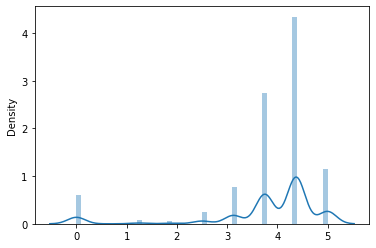

In [58]:
#check columns rating
import seaborn as sns
df=data6.select('rating')
sns.distplot(df.toPandas())
#check columns rating


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

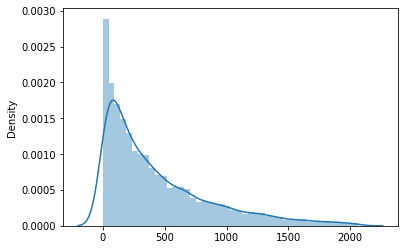

In [59]:
#check columns rating
df=data6.select('sodium')
sns.distplot(df.toPandas())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

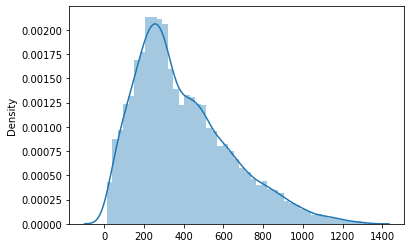

In [60]:
#check columns rating
df=data6.select('calories')
sns.distplot(df.toPandas())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

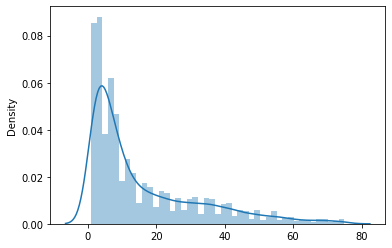

In [61]:
#check columns rating
df=data6.select('protein')
sns.distplot(df.toPandas())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

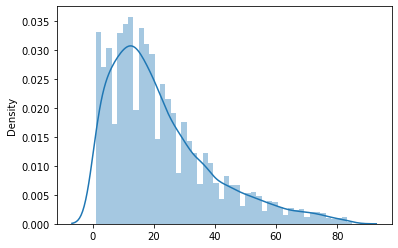

In [62]:
#check columns rating
df=data6.select('fat')
sns.distplot(df.toPandas())

In [64]:
# correctlation của các thuộc tính calories,fat,sodium,proten,..
def corr(a,b):
    print('coreclation cua',a,'va',b,'la:',data6.corr(a,b))
corr('calories','fat')
corr('calories','protein')
corr('calories','sodium')
corr('fat','sodium')
corr('fat','protein')
corr('protein','sodium')
corr('rating','sodium')
corr('rating','calories')
corr('rating','fat')
corr('rating','protein')

coreclation cua calories va fat la: 0.8489857878710382
coreclation cua calories va protein la: 0.6565678268551042
coreclation cua calories va sodium la: 0.42867463506314335
coreclation cua fat va sodium la: 0.34782700637822705
coreclation cua fat va protein la: 0.5489835043792513
coreclation cua protein va sodium la: 0.5253039018674166
coreclation cua rating va sodium la: 0.0774868963391573
coreclation cua rating va calories la: 0.10530933569401878
coreclation cua rating va fat la: 0.10880205265189782
coreclation cua rating va protein la: 0.09487155738563739


In [65]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
#Vecto "calories","fat","sodium","protein" to vector
#Predict rating
assembler=VectorAssembler(inputCols=["calories","fat","sodium","protein"],outputCol='features')
output=assembler.transform(data6)
output.select('features','rating').show(5)
#Vecto "calories","fat","sodium","protein" to vector
#Predict Calories
assembler1=VectorAssembler(inputCols=["fat","sodium","protein",'low cal'],outputCol='features')
output1=assembler1.transform(data6)
output1.select('features','calories').show(5)

+--------------------+------+
|            features|rating|
+--------------------+------+
|[629.0,52.0,292.0...| 4.375|
|[213.0,5.0,129.0,...| 4.375|
|[121.0,10.0,5.0,1.0]| 4.375|
|[113.0,9.0,314.0,...| 4.375|
|[331.0,10.0,93.0,...|  3.75|
+--------------------+------+
only showing top 5 rows

+--------------------+--------+
|            features|calories|
+--------------------+--------+
|[52.0,292.0,28.0,...|   629.0|
| [5.0,129.0,6.0,0.0]|   213.0|
|  [10.0,5.0,1.0,0.0]|   121.0|
| [9.0,314.0,7.0,0.0]|   113.0|
| [10.0,93.0,8.0,0.0]|   331.0|
+--------------------+--------+
only showing top 5 rows



In [66]:
#train calories
data7= output1.select('features','calories')
#chia dữ liệu train test
train, test = data7.randomSplit([0.7, 0.3], seed=42)
from pyspark.ml.regression import LinearRegression
#traijn LinearRegression
ship_lr=LinearRegression(featuresCol='features',labelCol='calories')
trained_ship_model=ship_lr.fit(train)
#đánh giá Rsquared
ship_results=trained_ship_model.evaluate(train)
print('Rsquared Error Train:',ship_results.r2)
print('RMSE Train',ship_results.rootMeanSquaredError)
ship_results=trained_ship_model.evaluate(test)
print('Rsquared Error Test:',ship_results.r2)
print('RMSE Test',ship_results.rootMeanSquaredError)

Rsquared Error Train: 0.7748075976384698
RMSE Train 114.27291666927685
Rsquared Error Test: 0.7788683399699513
RMSE Test 115.22328099117344


In [67]:
#datatest=data5.select('features')
from pyspark.sql.functions import concat, col, lit
predictions=trained_ship_model.transform(test.select('features'))
df3 = predictions.join(test, "features", "outer").drop("features").show()


+------------------+--------+
|        prediction|calories|
+------------------+--------+
|127.05823584570345|   143.0|
|133.10059495349833|    34.0|
|140.10710790012882|    43.0|
|164.79151133828566|    74.0|
|162.22704431149634|   171.0|
|242.35036724598018|   142.0|
| 218.0530278884814|   274.0|
|216.29743771087314|   204.0|
|226.06994973578125|   283.0|
| 261.5124214890409|   235.0|
| 311.6065999375403|   449.0|
| 264.5230421129927|   166.0|
| 445.7512352396748|   432.0|
| 281.6436724766586|   267.0|
|  313.701558645883|   261.0|
|357.00567525678787|   411.0|
|379.02242901935875|   360.0|
| 533.9733375455605|   424.0|
| 591.9092562895364|   651.0|
| 742.6911181430128|   641.0|
+------------------+--------+
only showing top 20 rows



In [ ]:
a.remove('rating')


In [107]:
b=a.copy()
train_data, test_data = data6.randomSplit([0.8,0.2])
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
#Predict Calories
assembler1=VectorAssembler(inputCols=b,outputCol='features')
output2=assembler1.transform(data6)
train_data1, test_data1 = output2.randomSplit([0.8,0.2])
output2.select('features','kosher').show(5)

IllegalArgumentException: kosher does not exist. Available: almond, anchovy, anise, appetizer, apple, apricot, asian pear, asparagus, aspen, avocado, bacon, bake, banana, barley, basil, bean, beef, beef rib, beef tenderloin, beet, bell pepper, berry, blue cheese, blueberry, boil, bread, breakfast, brie, brine, brisket, broccoli, broil, brown rice, brownie, brussel sprout, buffalo, burrito, butter, buttermilk, butternut squash, cabbage, cake, calories, candy, cantaloupe, capers, caraway, cardamom, carrot, cashew, cauliflower, caviar, celery, chard, cheese, cherry, chestnut, chicken, chili, chive, chocolate, cilantro, cinnamon, citrus, clove, coconut, cod, cookie, coriander, corn, cornmeal, cottage cheese, crab, cranberry, cranberry sauce, cream cheese, cucumber, cumin, cupcake, currant, curry, custard, dessert, dill, dinner, dip, dried fruit, duck, egg, eggplant, escarole, fat, fennel, fig, fish, flat bread, fritter, fruit, garlic, ginger, goat cheese, goose, granola, grape, grapefruit, green onion/scallion, grill, ground beef, guava, halibut, ham, hamburger, healthy, herb, high fiber, honey, horseradish, hot pepper, ice cream, iced tea, jam or jelly, kale, kiwi, kumquat, lamb, lamb chop, lamb shank, lasagna, leafy green, leek, legume, lemon, lemongrass, lentil, lettuce, lobster, low cal, lunch, lychee, macaroni and cheese, mango, marinade, marinate, meat, meatball, meatloaf, melon, mint, molasses, mozzarella, muffin, mushroom, mussel, mustard, mustard greens, noodle, nutmeg, oat, oatmeal, octopus, okra, olive, omelet, onion, orange, oregano, pancake, papaya, paprika, parsley, passion fruit, pasta, pastry, pea, peach, peanut, peanut butter, pear, pecan, pepper, persimmon, pickles, pie, pine nut, pineapple, pistachio, plantain, plum, pomegranate, pork, pork chop, pork rib, pork tenderloin, pot pie, potato, potato salad, poultry, poultry sausage, protein, pumpkin, quail, rabbit, radish, raisin, raspberry, red wine, rice, roast, rosemary, rye, saffron, sage, salad, salmon, sandwich, sardine, sauce, sausage, sauté, scallop, seafood, self, sesame, sesame oil, shallot, shrimp, simmer, skewer, snapper, sodium, sorbet, sour cream, sourdough, soy, soy sauce, spinach, squash, squid, steak, stew, strawberry, sugar snap pea, swiss cheese, swordfish, tamarind, tangerine, tapioca, tarragon, tested & improved, thyme, tilapia, tofu, tomato, tuna, turkey, turnip, veal, vegan, vegetable, vegetarian, venison, vinegar, walnut, watercress, watermelon, white wine, whole wheat, wild rice, yellow squash, yogurt, zucchini

In [100]:
data8=output2.select('features','kosher')
from pyspark.ml.classification import LogisticRegression
lrgen1 = LogisticRegression(labelCol="kosher", featuresCol="features", maxIter=100, regParam=0.001, elasticNetParam=1, standardization=True)
linearModelgen1 = lrgen1.fit(data8)
data8

AnalysisException: cannot resolve '`kosher`' given input columns: [almond, anchovy, anise, appetizer, apple, apricot, asian pear, asparagus, aspen, avocado, bacon, bake, banana, barley, basil, bean, beef, beef rib, beef tenderloin, beet, bell pepper, berry, blue cheese, blueberry, boil, bread, breakfast, brie, brine, brisket, broccoli, broil, brown rice, brownie, brussel sprout, buffalo, burrito, butter, buttermilk, butternut squash, cabbage, cake, calories, candy, cantaloupe, capers, caraway, cardamom, carrot, cashew, cauliflower, caviar, celery, chard, cheese, cherry, chestnut, chicken, chili, chive, chocolate, cilantro, cinnamon, citrus, clove, coconut, cod, cookie, coriander, corn, cornmeal, cottage cheese, crab, cranberry, cranberry sauce, cream cheese, cucumber, cumin, cupcake, currant, curry, custard, dessert, dill, dinner, dip, dried fruit, duck, egg, eggplant, escarole, fat, features, fennel, fig, fish, flat bread, fritter, fruit, garlic, ginger, goat cheese, goose, granola, grape, grapefruit, green onion/scallion, grill, ground beef, guava, halibut, ham, hamburger, healthy, herb, high fiber, honey, horseradish, hot pepper, ice cream, iced tea, jam or jelly, kale, kiwi, kumquat, lamb, lamb chop, lamb shank, lasagna, leafy green, leek, legume, lemon, lemongrass, lentil, lettuce, lobster, low cal, lunch, lychee, macaroni and cheese, mango, marinade, marinate, meat, meatball, meatloaf, melon, mint, molasses, mozzarella, muffin, mushroom, mussel, mustard, mustard greens, noodle, nutmeg, oat, oatmeal, octopus, okra, olive, omelet, onion, orange, oregano, pancake, papaya, paprika, parsley, passion fruit, pasta, pastry, pea, peach, peanut, peanut butter, pear, pecan, pepper, persimmon, pickles, pie, pine nut, pineapple, pistachio, plantain, plum, pomegranate, pork, pork chop, pork rib, pork tenderloin, pot pie, potato, potato salad, poultry, poultry sausage, protein, pumpkin, quail, rabbit, radish, raisin, raspberry, red wine, rice, roast, rosemary, rye, saffron, sage, salad, salmon, sandwich, sardine, sauce, sausage, sauté, scallop, seafood, self, sesame, sesame oil, shallot, shrimp, simmer, skewer, snapper, sodium, sorbet, sour cream, sourdough, soy, soy sauce, spinach, squash, squid, steak, stew, strawberry, sugar snap pea, swiss cheese, swordfish, tamarind, tangerine, tapioca, tarragon, tested & improved, thyme, tilapia, tofu, tomato, tuna, turkey, turnip, veal, vegan, vegetable, vegetarian, venison, vinegar, walnut, watercress, watermelon, white wine, whole wheat, wild rice, yellow squash, yogurt, zucchini];
'Project [features#369538, 'kosher]
+- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 248 more fields]
   +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 247 more fields]
      +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 247 more fields]
         +- Filter (sodium#184406 < cast(2063 as float))
            +- Filter (fat#184130 < cast(86 as float))
               +- Filter (protein#183854 < cast(76 as float))
                  +- Filter (calories#183578 < cast(1330 as float))
                     +- Filter (sodium#184406 > cast(0 as float))
                        +- Filter (fat#184130 > cast(0 as float))
                           +- Filter (protein#183854 > cast(0 as float))
                              +- Filter (calories#183578 > cast(0 as float))
                                 +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 249 more fields]
                                    +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                       +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                          +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                             +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                                +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                                   +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                                      +- Deduplicate [pepper#178922, cashew#178567, nutmeg#178876, salad#178997, mustard greens#178858, boil#178520, burrito#178547, plum#178939, iced tea#178749, peach#178915, peanut#178916, molasses#178849, saffron#178994, pancake#178899, cheese#178577, jam or jelly#178758, cupcake#178631, vegetable#179100, pot pie#178952, poultry#178956, candy#178560, scallop#179010, venison#179102, basil#178500, ... 251 more fields]
                                                         +- Filter AtLeastNNulls(n, almond#178474,anchovy#178476,anise#178477,appetizer#178481,apple#178482,apricot#178484,asian pear#178488,asparagus#178489,aspen#178490,avocado#178493,bacon#178496,bake#178497,banana#178498,barley#178499,basil#178500,bean#178503,beef#178504,beef rib#178505,beef tenderloin#178507,beet#178509,bell pepper#178510,berry#178511,blue cheese#178518,blueberry#178519,boil#178520,bread#178529,breakfast#178531,brie#178532,brine#178533,brisket#178534,broccoli#178535,broil#178537,brown rice#178539,brownie#178540,brussel sprout#178542,buffalo#178543,burrito#178547,butter#178548,buttermilk#178549,butternut squash#178550,cabbage#178552,cake#178553,calories#178461,candy#178560,cantaloupe#178562,capers#178563,caraway#178564,cardamom#178565,carrot#178566,cashew#178567,cauliflower#178569,caviar#178570,celery#178571,chard#178574,cheese#178577,cherry#178578,chestnut#178579,chicken#178581,chili#178585,chive#178587,chocolate#178588,cilantro#178591,cinnamon#178593,citrus#178594,clove#178596,coconut#178600,cod#178601,cookie#178613,coriander#178615,corn#178616,cornmeal#178617,cottage cheese#178619,crab#178621,cranberry#178622,cranberry sauce#178623,cream cheese#178624,cucumber#178629,cumin#178630,cupcake#178631,currant#178632,curry#178633,custard#178634,dessert#178641,dill#178643,dinner#178644,dip#178645,dried fruit#178650,duck#178653,egg#178657,eggplant#178659,escarole#178668,fat#178463,fennel#178673,fig#178675,fish#178676,flat bread#178678,frittata#178690,fritter#178691,fruit#178693,garlic#178697,ginger#178701,goat cheese#178702,goose#178703,granola#178709,grape#178710,grapefruit#178711,green onion/scallion#178714,grill#178715,ground beef#178717,guava#178720,halibut#178722,ham#178724,hamburger#178725,healthy#178731,herb#178732,high fiber#178733,honey#178736,horseradish#178739,hot pepper#178741,ice cream#178746,iced tea#178749,jam or jelly#178758,kale#178765,kiwi#178774,kosher#178775,kumquat#178777,lamb#178780,lamb chop#178781,lamb shank#178782,lasagna#178785,leafy green#178786,leek#178787,legume#178788,lemon#178789,lemongrass#178791,lentil#178792,lettuce#178793,lobster#178799,low cal#178805,lunch#178813,lychee#178814,macaroni and cheese#178816,mango#178819,marinade#178823,marinate#178824,meat#178832,meatball#178833,meatloaf#178834,melon#178835,mint#178845,molasses#178849,mozzarella#178853,muffin#178854,mushroom#178855,mussel#178856,mustard#178857,mustard greens#178858,noodle#178873,nutmeg#178876,oat#178877,oatmeal#178878,octopus#178879,okra#178882,olive#178884,omelet#178885,onion#178887,orange#178888,oregano#178890,pancake#178899,papaya#178900,paprika#178901,parsley#178905,passion fruit#178909,pasta#178911,pastry#178913,pea#178914,peach#178915,peanut#178916,peanut butter#178917,pear#178919,pecan#178920,pepper#178922,persimmon#178925,pickles#178930,pie#178932,pine nut#178933,pineapple#178934,pistachio#178935,plantain#178938,plum#178939,pomegranate#178943,pork#178946,pork chop#178947,pork rib#178948,pork tenderloin#178949,pot pie#178952,potato#178953,potato salad#178954,poultry#178956,poultry sausage#178957,protein#178462,pumpkin#178962,quail#178965,rabbit#178971,radish#178974,raisin#178975,raspberry#178978,rating#178460,red wine#178980,rice#178983,roast#178985,rosemary#178987,rye#178993,saffron#178994,sage#178995,salad#178997,salmon#178999,sandwich#179002,sardine#179006,sauce#179007,sausage#179008,sauté#179009,scallop#179010,seafood#179012,self#179015,sesame#179017,sesame oil#179018,shallot#179019,shrimp#179024,simmer#179026,skewer#179027,snapper#179031,sodium#178464,sorbet#179032,sour cream#179035,sourdough#179036,soy#179038,soy sauce#179040,spinach#179044,squash#179048,squid#179049,steak#179052,stew#179054,strawberry#179057,sugar snap pea#179060,swiss cheese#179066,swordfish#179068,tamarind#179071,tangerine#179072,tapioca#179073,tarragon#179074,tested & improved#179079,thyme#179082,tilapia#179083,tofu#179084,tomato#179086,tuna#179093,turkey#179138,turnip#179094,veal#179098,vegan#179099,vegetable#179100,vegetarian#179101,venison#179102,vinegar#179105,waffle#179108,walnut#179109,watercress#179113,watermelon#179114,white wine#179121,whole wheat#179122,wild rice#179123,yellow squash#179129,yogurt#179130,zucchini#179133)
                                                            +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                                               +- Relation[title#178459,rating#178460,calories#178461,protein#178462,fat#178463,sodium#178464,#cakeweek#178465,#wasteless#178466,22-minute meals#178467,3-ingredient recipes#178468,30 days of groceries#178469,advance prep required#178470,alabama#178471,alaska#178472,alcoholic#178473,almond#178474,amaretto#178475,anchovy#178476,anise#178477,anniversary#178478,anthony bourdain#178479,aperitif#178480,appetizer#178481,apple#178482,... 656 more fields] csv


In [95]:
data8.show()

+--------------------+------+
|            features|kosher|
+--------------------+------+
|[52.0,292.0,28.0,...|   0.0|
| [5.0,129.0,6.0,0.0]|   1.0|
|  [10.0,5.0,1.0,0.0]|   1.0|
| [9.0,314.0,7.0,0.0]|   0.0|
| [10.0,93.0,8.0,0.0]|   1.0|
|[13.0,142.0,4.0,0.0]|   0.0|
|[36.0,491.0,29.0,...|   0.0|
|  [7.0,18.0,5.0,0.0]|   0.0|
|[48.0,484.0,10.0,...|   1.0|
|[29.0,423.0,6.0,0.0]|   1.0|
|[29.0,502.0,20.0,...|   0.0|
|[36.0,691.0,11.0,...|   1.0|
|[11.0,193.0,4.0,0.0]|   0.0|
|[11.0,180.0,3.0,0.0]|   0.0|
|[37.0,183.0,5.0,0.0]|   0.0|
|[10.0,132.0,2.0,0.0]|   1.0|
| [4.0,318.0,4.0,0.0]|   1.0|
|   [4.0,6.0,3.0,0.0]|   1.0|
|[20.0,184.0,4.0,0.0]|   0.0|
|[23.0,1924.0,13.0...|   0.0|
+--------------------+------+
only showing top 20 rows



In [97]:
trainingSummary = linearModelgen1.summary

print(accuracy)

0.6497818088474373


In [94]:
predictions = linearModelgen1.transform(test_data1)
predictions.select('features','kosher').show(5)


AnalysisException: cannot resolve '`kosher`' given input columns: [almond, anchovy, anise, appetizer, apple, apricot, asian pear, asparagus, aspen, avocado, bacon, bake, banana, barley, basil, bean, beef, beef rib, beef tenderloin, beet, bell pepper, berry, blue cheese, blueberry, boil, bread, breakfast, brie, brine, brisket, broccoli, broil, brown rice, brownie, brussel sprout, buffalo, burrito, butter, buttermilk, butternut squash, cabbage, cake, calories, candy, cantaloupe, capers, caraway, cardamom, carrot, cashew, cauliflower, caviar, celery, chard, cheese, cherry, chestnut, chicken, chili, chive, chocolate, cilantro, cinnamon, citrus, clove, coconut, cod, cookie, coriander, corn, cornmeal, cottage cheese, crab, cranberry, cranberry sauce, cream cheese, cucumber, cumin, cupcake, currant, curry, custard, dessert, dill, dinner, dip, dried fruit, duck, egg, eggplant, escarole, fat, features, fennel, fig, fish, flat bread, fritter, fruit, garlic, ginger, goat cheese, goose, granola, grape, grapefruit, green onion/scallion, grill, ground beef, guava, halibut, ham, hamburger, healthy, herb, high fiber, honey, horseradish, hot pepper, ice cream, iced tea, jam or jelly, kale, kiwi, kumquat, lamb, lamb chop, lamb shank, lasagna, leafy green, leek, legume, lemon, lemongrass, lentil, lettuce, lobster, low cal, lunch, lychee, macaroni and cheese, mango, marinade, marinate, meat, meatball, meatloaf, melon, mint, molasses, mozzarella, muffin, mushroom, mussel, mustard, mustard greens, noodle, nutmeg, oat, oatmeal, octopus, okra, olive, omelet, onion, orange, oregano, pancake, papaya, paprika, parsley, passion fruit, pasta, pastry, pea, peach, peanut, peanut butter, pear, pecan, pepper, persimmon, pickles, pie, pine nut, pineapple, pistachio, plantain, plum, pomegranate, pork, pork chop, pork rib, pork tenderloin, pot pie, potato, potato salad, poultry, poultry sausage, prediction, probability, protein, pumpkin, quail, rabbit, radish, raisin, raspberry, rawPrediction, red wine, rice, roast, rosemary, rye, saffron, sage, salad, salmon, sandwich, sardine, sauce, sausage, sauté, scallop, seafood, self, sesame, sesame oil, shallot, shrimp, simmer, skewer, snapper, sodium, sorbet, sour cream, sourdough, soy, soy sauce, spinach, squash, squid, steak, stew, strawberry, sugar snap pea, swiss cheese, swordfish, tamarind, tangerine, tapioca, tarragon, tested & improved, thyme, tilapia, tofu, tomato, tuna, turkey, turnip, veal, vegan, vegetable, vegetarian, venison, vinegar, walnut, watercress, watermelon, white wine, whole wheat, wild rice, yellow squash, yogurt, zucchini];
'Project [features#366145, 'kosher]
+- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
   +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 250 more fields]
      +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 249 more fields]
         +- Sample 0.8, 1.0, false, 5751800983685515604
            +- Sort [almond#178474 ASC NULLS FIRST, anchovy#178476 ASC NULLS FIRST, anise#178477 ASC NULLS FIRST, appetizer#178481 ASC NULLS FIRST, apple#178482 ASC NULLS FIRST, apricot#178484 ASC NULLS FIRST, asian pear#178488 ASC NULLS FIRST, asparagus#178489 ASC NULLS FIRST, aspen#178490 ASC NULLS FIRST, avocado#178493 ASC NULLS FIRST, bacon#178496 ASC NULLS FIRST, bake#178497 ASC NULLS FIRST, banana#178498 ASC NULLS FIRST, barley#178499 ASC NULLS FIRST, basil#178500 ASC NULLS FIRST, bean#178503 ASC NULLS FIRST, beef#178504 ASC NULLS FIRST, beef rib#178505 ASC NULLS FIRST, beef tenderloin#178507 ASC NULLS FIRST, beet#178509 ASC NULLS FIRST, bell pepper#178510 ASC NULLS FIRST, berry#178511 ASC NULLS FIRST, blue cheese#178518 ASC NULLS FIRST, blueberry#178519 ASC NULLS FIRST, ... 248 more fields], false
               +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 248 more fields]
                  +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 247 more fields]
                     +- Filter (sodium#184406 < cast(2063 as float))
                        +- Filter (fat#184130 < cast(86 as float))
                           +- Filter (protein#183854 < cast(76 as float))
                              +- Filter (calories#183578 < cast(1330 as float))
                                 +- Filter (sodium#184406 > cast(0 as float))
                                    +- Filter (fat#184130 > cast(0 as float))
                                       +- Filter (protein#183854 > cast(0 as float))
                                          +- Filter (calories#183578 > cast(0 as float))
                                             +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 249 more fields]
                                                +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                                   +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                                      +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                                         +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                                            +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                                               +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                                                  +- Deduplicate [pepper#178922, cashew#178567, nutmeg#178876, salad#178997, mustard greens#178858, boil#178520, burrito#178547, plum#178939, iced tea#178749, peach#178915, peanut#178916, molasses#178849, saffron#178994, pancake#178899, cheese#178577, jam or jelly#178758, cupcake#178631, vegetable#179100, pot pie#178952, poultry#178956, candy#178560, scallop#179010, venison#179102, basil#178500, ... 251 more fields]
                                                                     +- Filter AtLeastNNulls(n, almond#178474,anchovy#178476,anise#178477,appetizer#178481,apple#178482,apricot#178484,asian pear#178488,asparagus#178489,aspen#178490,avocado#178493,bacon#178496,bake#178497,banana#178498,barley#178499,basil#178500,bean#178503,beef#178504,beef rib#178505,beef tenderloin#178507,beet#178509,bell pepper#178510,berry#178511,blue cheese#178518,blueberry#178519,boil#178520,bread#178529,breakfast#178531,brie#178532,brine#178533,brisket#178534,broccoli#178535,broil#178537,brown rice#178539,brownie#178540,brussel sprout#178542,buffalo#178543,burrito#178547,butter#178548,buttermilk#178549,butternut squash#178550,cabbage#178552,cake#178553,calories#178461,candy#178560,cantaloupe#178562,capers#178563,caraway#178564,cardamom#178565,carrot#178566,cashew#178567,cauliflower#178569,caviar#178570,celery#178571,chard#178574,cheese#178577,cherry#178578,chestnut#178579,chicken#178581,chili#178585,chive#178587,chocolate#178588,cilantro#178591,cinnamon#178593,citrus#178594,clove#178596,coconut#178600,cod#178601,cookie#178613,coriander#178615,corn#178616,cornmeal#178617,cottage cheese#178619,crab#178621,cranberry#178622,cranberry sauce#178623,cream cheese#178624,cucumber#178629,cumin#178630,cupcake#178631,currant#178632,curry#178633,custard#178634,dessert#178641,dill#178643,dinner#178644,dip#178645,dried fruit#178650,duck#178653,egg#178657,eggplant#178659,escarole#178668,fat#178463,fennel#178673,fig#178675,fish#178676,flat bread#178678,frittata#178690,fritter#178691,fruit#178693,garlic#178697,ginger#178701,goat cheese#178702,goose#178703,granola#178709,grape#178710,grapefruit#178711,green onion/scallion#178714,grill#178715,ground beef#178717,guava#178720,halibut#178722,ham#178724,hamburger#178725,healthy#178731,herb#178732,high fiber#178733,honey#178736,horseradish#178739,hot pepper#178741,ice cream#178746,iced tea#178749,jam or jelly#178758,kale#178765,kiwi#178774,kosher#178775,kumquat#178777,lamb#178780,lamb chop#178781,lamb shank#178782,lasagna#178785,leafy green#178786,leek#178787,legume#178788,lemon#178789,lemongrass#178791,lentil#178792,lettuce#178793,lobster#178799,low cal#178805,lunch#178813,lychee#178814,macaroni and cheese#178816,mango#178819,marinade#178823,marinate#178824,meat#178832,meatball#178833,meatloaf#178834,melon#178835,mint#178845,molasses#178849,mozzarella#178853,muffin#178854,mushroom#178855,mussel#178856,mustard#178857,mustard greens#178858,noodle#178873,nutmeg#178876,oat#178877,oatmeal#178878,octopus#178879,okra#178882,olive#178884,omelet#178885,onion#178887,orange#178888,oregano#178890,pancake#178899,papaya#178900,paprika#178901,parsley#178905,passion fruit#178909,pasta#178911,pastry#178913,pea#178914,peach#178915,peanut#178916,peanut butter#178917,pear#178919,pecan#178920,pepper#178922,persimmon#178925,pickles#178930,pie#178932,pine nut#178933,pineapple#178934,pistachio#178935,plantain#178938,plum#178939,pomegranate#178943,pork#178946,pork chop#178947,pork rib#178948,pork tenderloin#178949,pot pie#178952,potato#178953,potato salad#178954,poultry#178956,poultry sausage#178957,protein#178462,pumpkin#178962,quail#178965,rabbit#178971,radish#178974,raisin#178975,raspberry#178978,rating#178460,red wine#178980,rice#178983,roast#178985,rosemary#178987,rye#178993,saffron#178994,sage#178995,salad#178997,salmon#178999,sandwich#179002,sardine#179006,sauce#179007,sausage#179008,sauté#179009,scallop#179010,seafood#179012,self#179015,sesame#179017,sesame oil#179018,shallot#179019,shrimp#179024,simmer#179026,skewer#179027,snapper#179031,sodium#178464,sorbet#179032,sour cream#179035,sourdough#179036,soy#179038,soy sauce#179040,spinach#179044,squash#179048,squid#179049,steak#179052,stew#179054,strawberry#179057,sugar snap pea#179060,swiss cheese#179066,swordfish#179068,tamarind#179071,tangerine#179072,tapioca#179073,tarragon#179074,tested & improved#179079,thyme#179082,tilapia#179083,tofu#179084,tomato#179086,tuna#179093,turkey#179138,turnip#179094,veal#179098,vegan#179099,vegetable#179100,vegetarian#179101,venison#179102,vinegar#179105,waffle#179108,walnut#179109,watercress#179113,watermelon#179114,white wine#179121,whole wheat#179122,wild rice#179123,yellow squash#179129,yogurt#179130,zucchini#179133)
                                                                        +- Project [almond#178474, anchovy#178476, anise#178477, appetizer#178481, apple#178482, apricot#178484, asian pear#178488, asparagus#178489, aspen#178490, avocado#178493, bacon#178496, bake#178497, banana#178498, barley#178499, basil#178500, bean#178503, beef#178504, beef rib#178505, beef tenderloin#178507, beet#178509, bell pepper#178510, berry#178511, blue cheese#178518, blueberry#178519, ... 251 more fields]
                                                                           +- Relation[title#178459,rating#178460,calories#178461,protein#178462,fat#178463,sodium#178464,#cakeweek#178465,#wasteless#178466,22-minute meals#178467,3-ingredient recipes#178468,30 days of groceries#178469,advance prep required#178470,alabama#178471,alaska#178472,alcoholic#178473,almond#178474,amaretto#178475,anchovy#178476,anise#178477,anniversary#178478,anthony bourdain#178479,aperitif#178480,appetizer#178481,apple#178482,... 656 more fields] csv


0.9005390835579515


NameError: name 'testData1' is not defined

In [73]:
# Evaluate Random Forest Model
from pyspark.mllib.evaluation import MulticlassMetrics

# Instantiate metrics object
metrics = lrgen1.(labels_and_predictions)
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

SyntaxError: invalid syntax (<ipython-input-73-aecc40a4ec7c>, line 5)

In [74]:

ship_results=lrgen1.evaluate(train_data1)
print('Rsquared Error Train:',ship_results)
print('RMSE Train',ship_results.rootMeanSquaredError)
ship_results=lrgen1.evaluate(test_data1)
print('Rsquared Error Test:',ship_results.r2)
print('RMSE Test',ship_results.rootMeanSquaredError)

AttributeError: 'LogisticRegression' object has no attribute 'evaluate'